<a href="https://colab.research.google.com/github/Eylz-Liu/Mod-le-vol-locale/blob/main/Etude_local_vol_Dupire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## La courbe des taux

On se donne la courbe zéro-coupon en interpolant ses piliers avec des splines cubiques et on définit quelques fonctions utiles pour la suite...

In [ ]:
import numpy as np
import math
from scipy.interpolate import interp1d

# yield curve (zero rates)
yc_maturities = np.array([0, 1, 2, 5, 10, 15, 20, 30])
yc_zc_rates = np.array([-0.55, -0.52, -0.51, -0.4,  -0.18,  0.02,  0.11,  0.09]) * 0.01
yc_zc_rates_interp = interp1d(yc_maturities, yc_zc_rates, kind='cubic', fill_value="extrapolate")

def zc_rate(T) :
    return yc_zc_rates_interp(T)

def DF(T) :
    return math.exp(-yc_zc_rates_interp(T)*T)

Voyons voir à quoi ressemble notre courbe ZC :


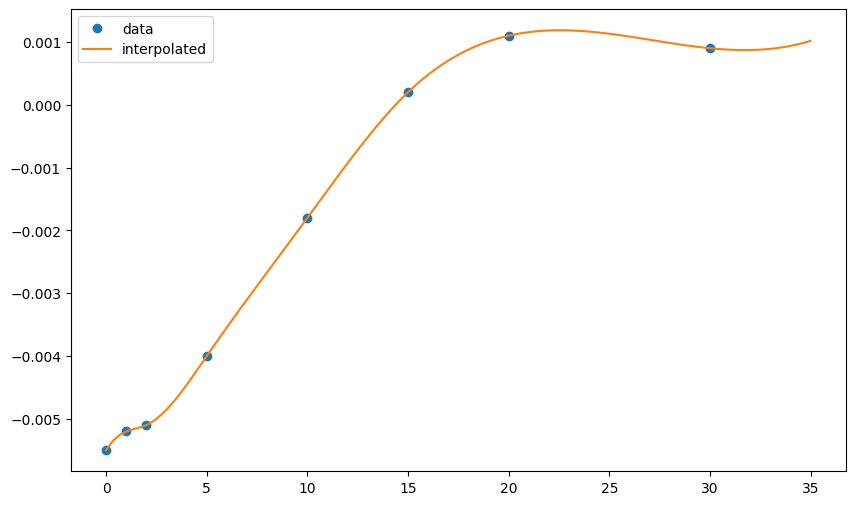

In [ ]:
# plot zc curve
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
maturities = np.linspace(0, 35, num=101, endpoint=True)
plt.plot(yc_maturities, yc_zc_rates, 'o', maturities, zc_rate(maturities))
plt.legend(['data', 'interpolated'], loc='best')
plt.show()

# Scénario 1 - Simulation d'un mini Dupire


Afin d'introduire les modèles à volatilité locale via la formule de Dupire, nous utilisons un exemple pratique avec une surface de volatilité implicite de l'Euro Stoxx 50 (SXE5), extraite de Bloomberg

'Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50' (%):
          80%   90%   95%  100%  105%  110%  120%
0.08 an  36.2  24.0  18.7  14.4  12.1  13.2  20.4
0.25 an  27.8  21.0  18.1  15.6  13.9  13.1  13.8
0.50 an  24.9  20.0  17.7  15.9  14.6  13.8  13.2
1.00 an  22.9  19.5  18.0  16.7  16.1  15.7  14.9
2.00 an  21.6  19.3  18.3  17.4  16.7  16.0  14.9


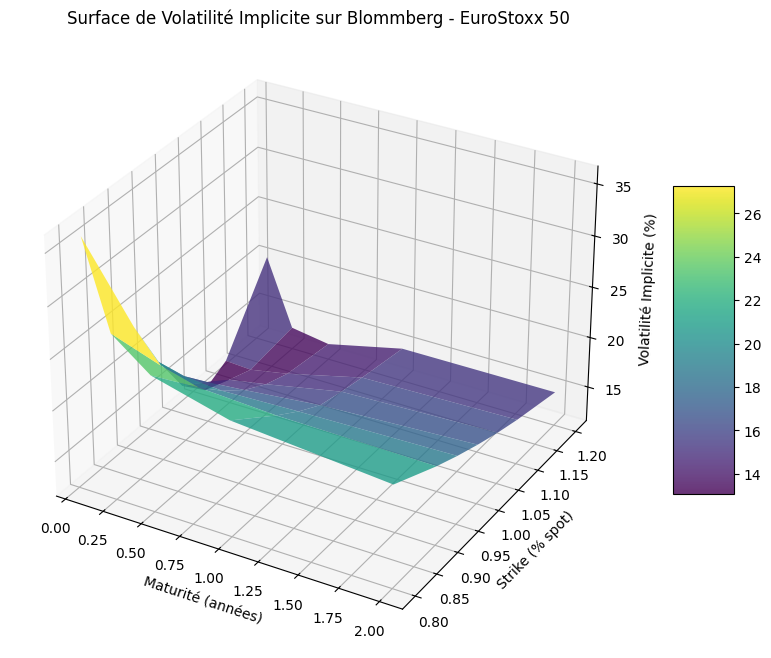

In [ ]:
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
# ************ 1. collecte des données   ***************************
T = np.array ( [0.08, 0.25, 0.5, 1.0, 2.0 ] )  # Maturité en année
K = np.array ((0.8, 0.9,0.95, 1.0,1.05, 1.1, 1.2 ) )     # spot price
spot_price = 5655     # Prix spot fictif de l'EuroStoxx 50

# Grille de maturités (en années)
maturities = np.array([0.08, 0.25, 0.5, 1.0, 2.0])

# Grille de strikes (en % du spot)
strike_ratios = np.array([0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.2])
strikes = strike_ratios * spot_price

# Surface de volatilité implicite fictive (en %) # Dimensions: 5 maturités × 7 strikes
iv_matrix = np.array([
    # 80%    90%    95%    100%    105%    110%    120%  (strike ratios)
    [36.19, 24.03, 18.72,  14.41,  12.07,  13.24,  20.37],  # 1 mois (0.08 an) 5/12/2025
    [27.79, 21.00, 18.06,  15.58,  13.92,  13.08,  13.76],  # 3 mois (0.25 an) 20/02/2026
    [24.91, 19.95, 17.74,  15.91,  14.60,  13.79,  13.15],  # 6 mois (0.5 an)  15/05/2026
    [22.91, 19.52, 17.98,  16.68,  16.13,  15.66,  14.89],  # 1 an (1.0 an)    20/11/2026
    [21.59, 19.31, 18.32,  17.44,  16.66,  16.00,  14.93]    # 2 ans (2.0 an)   07/11/2027
])

# Surface de volatilité implicite fictive (en %) # Dimensions: 5 maturités × 7 strikes
iv_matrix2 = np.array([
    # 80%    90%    95%    100%    105%    110%    120%  (strike ratios)
    [88.94, 59.04, 36.85,  16.97,  23.49,  37.12,  53.28],  # 1 day (0.003 an)   07/11/2027
    [36.19, 24.03, 18.72,  14.41,  12.07,  13.24,  20.37],  # 1 mois (0.08 an) 5/12/2025
    [27.79, 21.00, 18.06,  15.58,  13.92,  13.08,  13.76],  # 3 mois (0.25 an) 20/02/2026
    [24.91, 19.95, 17.74,  15.91,  14.60,  13.79,  13.15],  # 6 mois (0.5 an)  15/05/2026
    [22.91, 19.52, 17.98,  16.68,  16.13,  15.66,  14.89],  # 1 an (1.0 an)    20/11/2026

])

# Création d'un DataFrame pour une meilleure visualisation
iv_df = pd.DataFrame(
    iv_matrix,
    index=[f'{m:.2f} an' for m in maturities],
    columns=[f'{ratio:.0%}' for ratio in strike_ratios]
)

print("'Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50' (%):")
print(iv_df.round(1))
# IV_surface = interpolate.rectBivaruateSoline(T,K,IV,kx=3,ky=3,s=0.1)
# IV_surface = iv_df
# print(IV_surface.round(1))

# Création de la grille
T_mesh, K_mesh = np.meshgrid(maturities, strike_ratios)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface 3D
surf = ax.plot_surface(T_mesh, K_mesh, iv_matrix.T, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)

ax.set_xlabel('Maturité (années)')
ax.set_ylabel('Strike (% spot)')
ax.set_zlabel('Volatilité Implicite (%)')
ax.set_title('Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50')

plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

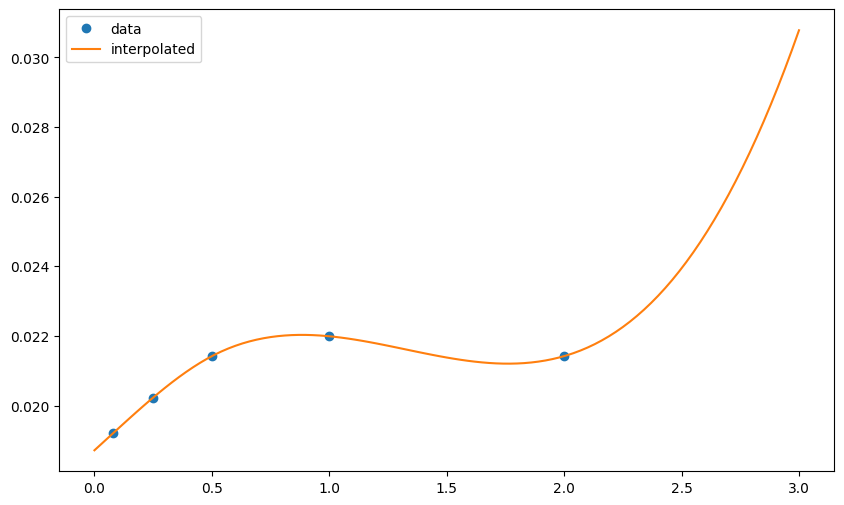

In [ ]:
from scipy import interpolate

# Taux sans risque r(T):
rates_dates = np.array([0.08, 0.25, 0.5, 1.0, 2.0])  # maturités
#rates_dates = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ])

rates_values = np.array([0.01921, 0.02023, 0.02142, 0.02199, 0.02142])  # taux
rate_curve = interpolate.interp1d(rates_dates, rates_values,kind='cubic', fill_value='extrapolate')
r = rate_curve(T)

# Taux de dividende q(T):
# Méthode 1: Dividendes implicites depuis les forwards
# Méthode 2: Dividendes explicites actualisés q = 0.02

dividend_dates = np.array([0.08, 0.25, 0.5, 1.0, 2.0])  # maturités
#dividend_dates = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ])

dividend_values = np.array([0.02, 0.02, 0.02, 0.02, 0.02])  # taux
dividend_curve = interpolate.interp1d(rates_dates, rates_values, kind='cubic', fill_value='extrapolate')

q = dividend_curve(T)

# plot zc curve interpolated
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
maturities = np.linspace(0, 3, num=101, endpoint=True)
plt.plot(rates_dates, rates_values, 'o', maturities, rate_curve(maturities))
plt.legend(['data', 'interpolated'], loc='best')
plt.show()

In [ ]:
# *******************************************************

K_array = strikes
IV_array = iv_matrix / 100  # Conversion en decimal (0.225 au lieu de 22.5%)

# Création de la surface d'interpolation
iv_surface = interpolate.RectBivariateSpline(
    T_array, K_array, IV_array,
    kx=3, ky=3, s=0.1  # s = paramètre de lissage
)

# Exemple d'évaluation en un point
T_test = 0.08  # 9 mois
K_test = 5655  # strike

iv_interpolated = iv_surface(T_test, K_test)[0][0]
print(f"Vol implicite interpolée pour T={T_test} an, K={K_test}: {iv_interpolated:.1%}")
# Output: Vol implicite interpolée pour T=0.75 an, K=4000: 19.5% ```

# Vérification de la Surface

def check_surface_quality(iv_surface, T_array, K_array):
    """Vérifie que la surface interpolée est raisonnable"""

    # Test de monotonie
    print("Vérification de la surface...")

    # Test sur des points intermédiaires
    test_points = [
        (0.08, 4480), (0.15, 4480),(0.25, 4480), (0.4, 4480),(0.5, 4480), (0.75, 4480), (1.0, 4480),
        (0.08, 6720), (0.15, 3500), (0.4, 3700), (0.75, 3900), (1.5, 4100)
    ]

    for T, K in test_points:
        iv = iv_surface(T, K)[0][0]
        print(f"T={T:.2f}, K={K}: vol = {iv:.1%}")

    return True

# check_surface_quality(iv_surface, T_array, K_array)
check_surface_quality(iv_surface, T, K)

Vol implicite interpolée pour T=0.08 an, K=5655: 15.4%
Vérification de la surface...
T=0.08, K=4480: vol = 29.8%
T=0.15, K=4480: vol = 26.5%
T=0.25, K=4480: vol = 23.6%
T=0.40, K=4480: vol = 22.6%
T=0.50, K=4480: vol = 23.3%
T=0.75, K=4480: vol = 25.6%
T=1.00, K=4480: vol = 21.6%
T=0.08, K=6720: vol = 14.9%
T=0.15, K=3500: vol = 26.5%
T=0.40, K=3700: vol = 22.6%
T=0.75, K=3900: vol = 25.6%
T=1.50, K=4100: vol = 21.6%


True

ÉTAPE 3: Calcul des Dérivées

In [ ]:
def calculate_dupire_local_vol_bis(T, K, spot, r, q):
    # 1. Volatilité implicite et ses dérivées
    iv = iv_surface(T, K)[0][0]

    # Dérivée par rapport au temps (dT = petit incrément)
    dT = 1e-07
    iv_T_plus = iv_surface(T + dT, K)[0][0]
    dIV_dT = (iv_T_plus - iv) / dT

    # Dérivée première par rapport à K
    dK = 0.01 * spot
    iv_K_plus = iv_surface(T, K + dK)[0][0]
    iv_K_minus = iv_surface(T, K - dK)[0][0]
    dIV_dK = (iv_K_plus - iv_K_minus) / (2 * dK)

    # Dérivée seconde par rapport à K
    d2IV_dK2 = (iv_K_plus - 2*iv + iv_K_minus) / (dK**2)

    # 2. Calcul de d+
    d_plus = (np.log(spot/K) + (r - q + 0.5*iv**2)*T) / (iv * np.sqrt(T))

    # 3. Application formule Dupire
    numerator = 2*dIV_dT + iv/T + 2*K*(r - q)*dIV_dK

    denominator_term1 = d2IV_dK2
    denominator_term2 = -d_plus * np.sqrt(T) * (dIV_dK)**2
    denominator_term3 = (1/iv) * (1/(K*np.sqrt(T)) + d_plus*dIV_dK)**2

    denominator = K**2 * (denominator_term1 + denominator_term2 + denominator_term3)

    local_var = numerator / denominator
    return np.sqrt(max(local_var, 0))  # éviter les variances négatives ```



In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! version fonction just pour test !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def calculate_dupire_local_vol(T, K, spot, r, q):
    # 1. Volatilité implicite et ses dérivées
    iv = iv_surface(T, K)[0][0]
    if iv == 0:
        print(f"[T={T}, K={K}] ⚠️ Volatilité implicite nulle")

    # Dérivée par rapport au temps
    dT = 1e-07
    iv_T_plus = iv_surface(T + dT, K)[0][0]
    dIV_dT = (iv_T_plus - iv) / dT

    # Dérivée première par rapport à K
    dK = dT * spot
    iv_K_plus = iv_surface(T, K + dK)[0][0]
    iv_K_minus = iv_surface(T, K - dK)[0][0]
    dIV_dK = (iv_K_plus - iv_K_minus) / (2 * dK)

    # Dérivée seconde par rapport à K
    d2IV_dK2 = (iv_K_plus - 2 * iv + iv_K_minus) / (dK ** 2)

    # 2. Calcul de d+
    try:
        d_plus = (np.log(spot / K) + (r - q + 0.5 * iv ** 2) * T) / (iv * np.sqrt(T))
    except ZeroDivisionError:
        print(f"[T={T}, K={K}] ⚠️ Division par zéro dans d_plus")
        return 0

    # 3. Application formule Dupire
    numerator = 2 * dIV_dT + iv / T + 2 * K * (r - q) * dIV_dK
    denominator_term1 = d2IV_dK2
    # print(f"[T={T}, K={K}]")
    # print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
    denominator_term2 = -d_plus * np.sqrt(T) * (dIV_dK) ** 2
    denominator_term3 = (1 / iv) * (1 / (K * np.sqrt(T)) + d_plus * dIV_dK) ** 2

    denominator = K ** 2 * (denominator_term1 + denominator_term2 + denominator_term3)
#--------------------------------------------------------------------------------------------------------------------------------------
#    if denominator == 0:
#       print(f"[T={T}, K={K}] ⚠️ Dénominateur exactement nul dans la formule de Dupire")
#        return 0
#    elif denominator < 0:
#        print(f"[T={T}, K={K}] ⚠️ Dénominateur négatif dans la formule de Dupire : {denominator}")
#        return 0


    #if denominator == 0:
    #    print(f"[T={T}, K={K}] ⚠️ Dénominateur exactement nul dans la formule de Dupire")
    #    print(f"  ➤ Termes du dénominateur :")
    #    print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
    #    print(f"     - Term2 (-d⁺√T·(dIV/dK)²) = {denominator_term2}")
    #    print(f"     - Term3 (1/IV · ...)     = {denominator_term3}")
    #    return 0
    #elif denominator < 0:
    #     print(f"[T={T}, K={K}] ⚠️ Dénominateur négatif dans la formule de Dupire : {denominator}")
    #     print(f"  ➤ Termes du dénominateur :")
    #     print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
    #     print(f"     - Term2 (-d⁺√T·(dIV/dK)²) = {denominator_term2}")
    #     print(f"     - Term3 (1/IV · ...)     = {denominator_term3}")
    #     return 0

# -------------------------------------------------------------------------------------------------------------------------------------------
    local_var = numerator / denominator
    if local_var <= 0:
        print(f"[T={T}, K={K}] ⚠️ Variance locale négative ou nulle : {local_var}")
        return 0

    return np.sqrt(local_var)

ÉTAPE 4: Paramètres de Marché

ÉTAPE 5: Calcul Systématique

In [ ]:
# Grille de calcul:
T_grid = T_array
K_grid = K_array

local_vol_grid = np.zeros((len(T_grid), len(K_grid)))

for i, T_val in enumerate(T_grid):
    for j, K_val in enumerate(K_grid):
        r_val = rate_curve(T_val)
        q_val = dividend_curve(T_val)  # si disponible

        local_vol_grid[i,j] = calculate_dupire_local_vol( T_val, K_val, spot_price, r_val, q_val)

print("Grille de volatilité locale :")
print(local_vol_grid)


[T=0.003, K=4524.0] ⚠️ Variance locale négative ou nulle : -1.4562628009738616e-05
[T=0.003, K=6786.0] ⚠️ Variance locale négative ou nulle : -3.5418022281022963e-06
[T=0.08, K=4524.0] ⚠️ Variance locale négative ou nulle : -4.5628409245509913e-07
[T=0.08, K=6786.0] ⚠️ Variance locale négative ou nulle : -1.3426862847759428e-07
[T=0.25, K=4524.0] ⚠️ Variance locale négative ou nulle : -1.9450490094228317e-07
[T=0.5, K=4524.0] ⚠️ Variance locale négative ou nulle : -2.2976799555913167e-07
[T=0.5, K=6786.0] ⚠️ Variance locale négative ou nulle : -1.5259085478289908e-06
[T=1.0, K=4524.0] ⚠️ Variance locale négative ou nulle : -1.356192505235041e-07
Grille de volatilité locale :
[[0.00000000e+00 4.09044737e-01 2.39368549e-01 1.49044714e-01
  1.16945094e-01 1.48646952e-01 0.00000000e+00]
 [0.00000000e+00 2.91145028e-01 2.08986167e-01 1.55437230e-01
  1.27527910e-01 1.25667178e-01 0.00000000e+00]
 [0.00000000e+00 2.15058397e-01 1.90717193e-01 1.69298415e-01
  1.49811101e-01 1.31305552e-01 4.

In [ ]:
# !!!!!!!!!! Grille de calcul: !!!!!!!!!!!!!!!!!  version détecter vol locale = 0  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
T_grid = T_array
K_grid = K_array

local_vol_grid = np.zeros((len(T_grid), len(K_grid)))

for i, T_val in enumerate(T_grid):
    for j, K_val in enumerate(K_grid):
        r_val = rate_curve(T_val)
        q_val = dividend_curve(T_val)  # si disponible

        # calculate_dupire_local_vol( T_val, K_val, spot_price, r_val, q_val)

        vol = calculate_dupire_local_vol(T_val, K_val, spot_price, r_val, q_val)

        if vol == 0:
            print(f"⚠️ Alerte : Volatilité locale nulle détectée pour T={T_val}, K={K_val} — valeur ignorée.")
            continue  # saute cette itération

        local_vol_grid[i, j] = vol

print("\nGrille de volatilité locale :")
for i, T_val in enumerate(T_grid):
    for j, K_val in enumerate(K_grid):
        vol = local_vol_grid[i, j]
        print(f"Vol[T={T_val:.4f}, K={K_val:.2f}] = {vol:.6f}")


[T=0.003, K=4524.0] ⚠️ Variance locale négative ou nulle : -1.4562628009738616e-05
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.003, K=4524.0 — valeur ignorée.
[T=0.003, K=6786.0] ⚠️ Variance locale négative ou nulle : -3.5418022281022963e-06
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.003, K=6786.0 — valeur ignorée.
[T=0.08, K=4524.0] ⚠️ Variance locale négative ou nulle : -4.5628409245509913e-07
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.08, K=4524.0 — valeur ignorée.
[T=0.08, K=6786.0] ⚠️ Variance locale négative ou nulle : -1.3426862847759428e-07
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.08, K=6786.0 — valeur ignorée.
[T=0.25, K=4524.0] ⚠️ Variance locale négative ou nulle : -1.9450490094228317e-07
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.25, K=4524.0 — valeur ignorée.
[T=0.5, K=4524.0] ⚠️ Variance locale négative ou nulle : -2.2976799555913167e-07
⚠️ Alerte : Volatilité locale nulle détectée pour T=0.5, K=4524.0 — valeur ignor

ÉTAPE 6: Validation et Contrôles

In [ ]:
# Vérifications essentielles:
# 1. Pas de volatilités négatives
if np.any(local_vol_grid == 0):
    print("ATTENTION: Volatilités locales nulle détectées!")

# 2. Vérification de la monotonie
# La surface doit être raisonnablement lisse

# 3. Comparaison avec limites connues
# Pour T→0, la vol locale → vol implicite ```


ATTENTION: Volatilités locales nulle détectées!


ÉTAPE 7: Visualisation

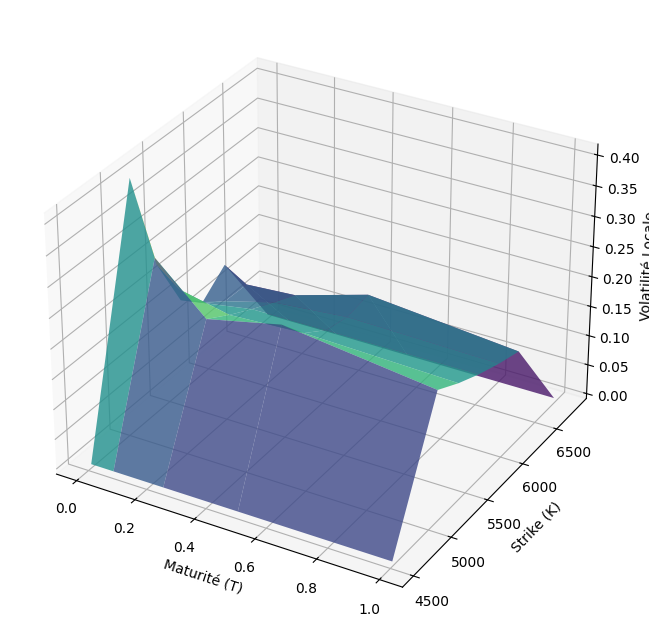

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

T_mesh, K_mesh = np.meshgrid(T_grid, K_grid)
surf = ax.plot_surface(T_mesh, K_mesh, local_vol_grid.T, cmap='viridis', alpha=0.8)

ax.set_xlabel('Maturité (T)')
ax.set_ylabel('Strike (K)')
ax.set_zlabel('Volatilité Locale')
plt.show()


EXEMPLE PRATIQUE COMPLET


In [ ]:
# Paramètres EuroStoxx 50
spot = 3800  # prix spot SX5E
T_calc = 0.08  # 1 an
K_calc = 4400  # strike

# Calcul pour un point
local_vol = calculate_dupire_local_vol(
    T=T_calc,
    K=K_calc,
    spot=spot,
    r=0.04,      # taux 1 an
    q=0.02       # dividende
)

print(f"Volatilité locale pour T={T_calc}, K={K_calc}: {local_vol:.1%}")


Volatilité locale pour T=0.08, K=4400: 24.8%


Etude de tendance


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paramètres de base
spot = 4400
r = 0.04
q = 0.02
pas = 100

# Grilles de T et K
T_values = [0.08, 0.25, 0.5, 1, 2]
#K = np.array ((0.8, 0.9, 1.0, 1.1, 1.2 ) )
K_values = np.linspace(3279, 5695, pas)

# Stockage des résultats
data = []

for T in T_values:
    for K in K_values:
        vol = calculate_dupire_local_vol(T=T, K=K, spot=spot, r=r, q=q)
        data.append({'T': T, 'K': K, 'local_vol': vol})

# Création du DataFrame
df = pd.DataFrame(data)



        T            K  local_vol
94   0.08  5572.979798   0.093218
95   0.08  5597.383838   0.092048
96   0.08  5621.787879   0.090979
97   0.08  5646.191919   0.090009
98   0.08  5670.595960   0.089151
99   0.08  5695.000000   0.088405
194  0.25  5572.979798   0.121362
195  0.25  5597.383838   0.120440
196  0.25  5621.787879   0.119495
197  0.25  5646.191919   0.118544
198  0.25  5670.595960   0.117620
199  0.25  5695.000000   0.116685
294  0.50  5572.979798   0.135868
295  0.50  5597.383838   0.135023
296  0.50  5621.787879   0.134304
297  0.50  5646.191919   0.133622
298  0.50  5670.595960   0.133068
299  0.50  5695.000000   0.132671
394  1.00  5572.979798   0.142000
395  1.00  5597.383838   0.140990
396  1.00  5621.787879   0.140110
397  1.00  5646.191919   0.138991
398  1.00  5670.595960   0.138001
399  1.00  5695.000000   0.137031
494  2.00  5572.979798   0.139435
495  2.00  5597.383838   0.138457
496  2.00  5621.787879   0.137717
497  2.00  5646.191919   0.136486
498  2.00  567

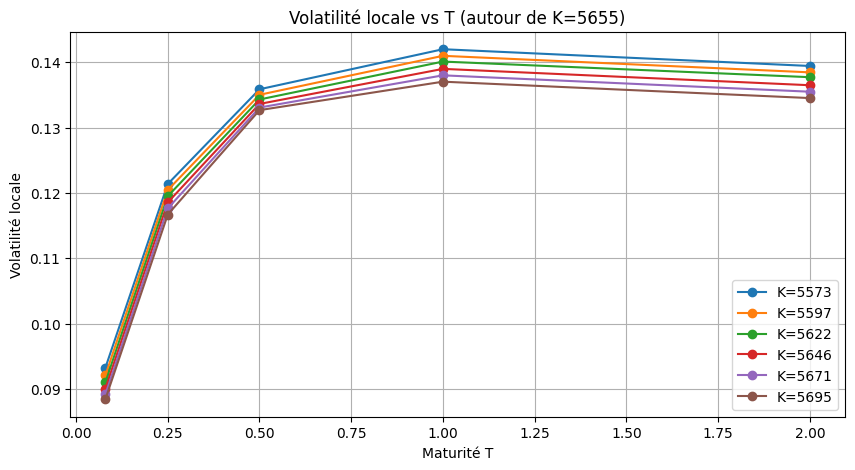

In [ ]:
# Plot 1 : Volatilité locale en fonction de T pour un K fixe - Low point pendant 5ans : 3279
K_target = 5655
df_T = df[np.abs(df['K'] - K_target) < pas]  # tolérance autour de K_target
print (df_T )
plt.figure(figsize=(10, 5))
for k in sorted(df_T['K'].unique()):
    subset = df_T[df_T['K'] == k]
    plt.plot(subset['T'], subset['local_vol'], marker='o', label=f'K={k:.0f}')
plt.title(f"Volatilité locale vs T (autour de K={K_target})")
plt.xlabel("Maturité T")
plt.ylabel("Volatilité locale")
plt.legend()
plt.grid(True)
plt.show()

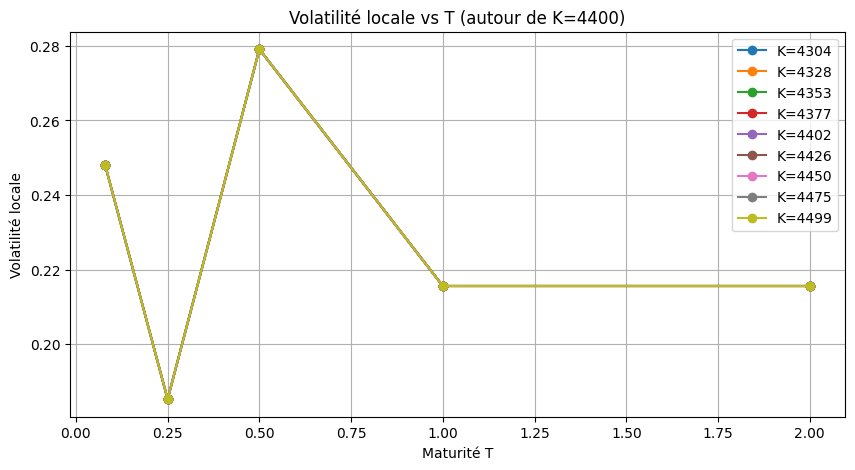

In [ ]:
# Plot 1.2 : Volatilité locale en fonction de T pour un K fixe - average point pendant 5ans : 4400
K_target = 4400
df_T = df[np.abs(df['K'] - K_target) < pas ]  # tolérance autour de K_target

plt.figure(figsize=(10, 5))
for k in sorted(df_T['K'].unique()):
    subset = df_T[df_T['K'] == k]
    plt.plot(subset['T'], subset['local_vol'], marker='o', label=f'K={k:.0f}')
plt.title(f"Volatilité locale vs T (autour de K={K_target})")
plt.xlabel("Maturité T")
plt.ylabel("Volatilité locale")
plt.legend()
plt.grid(True)
plt.show()


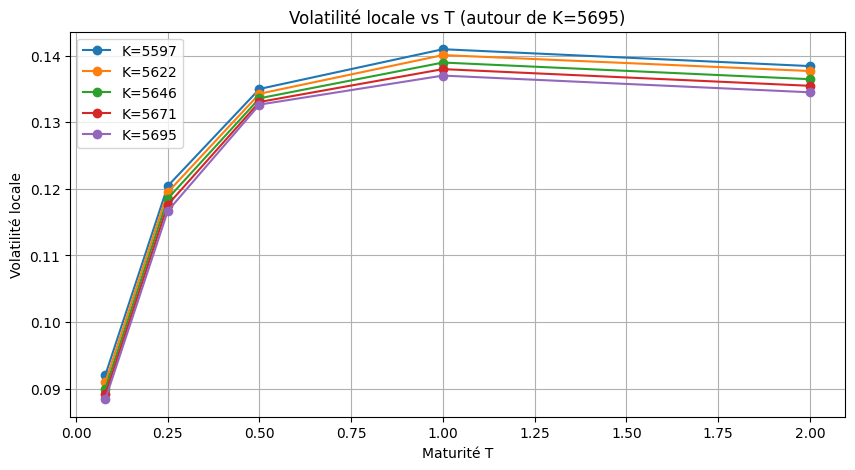

In [ ]:
# Plot 1.3 : Volatilité locale en fonction de T pour un K fixe - average point pendant 5ans : 5695
K_target = 5695
df_T = df[np.abs(df['K'] - K_target) < pas]  # tolérance autour de K_target

plt.figure(figsize=(10, 5))
for k in sorted(df_T['K'].unique()):
    subset = df_T[df_T['K'] == k]
    plt.plot(subset['T'], subset['local_vol'], marker='o', label=f'K={k:.0f}')
plt.title(f"Volatilité locale vs T (autour de K={K_target})")
plt.xlabel("Maturité T")
plt.ylabel("Volatilité locale")
plt.legend()
plt.grid(True)
plt.show()


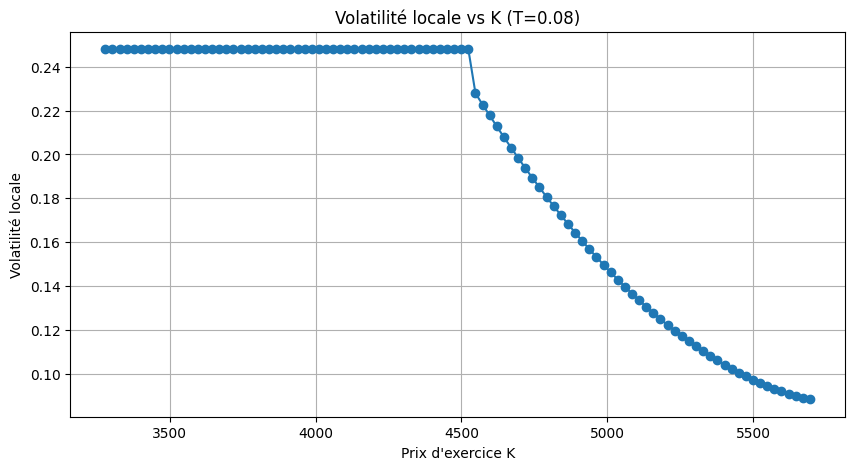

In [ ]:
# 📈 Plot 2 : Volatilité locale en fonction de K pour un T fixe monthly
T_target = 0.08
df_K = df[df['T'] == T_target]

plt.figure(figsize=(10, 5))
plt.plot(df_K['K'], df_K['local_vol'], marker='o')
plt.title(f"Volatilité locale vs K (T={T_target})")
plt.xlabel("Prix d'exercice K")
plt.ylabel("Volatilité locale")
plt.grid(True)
plt.show()

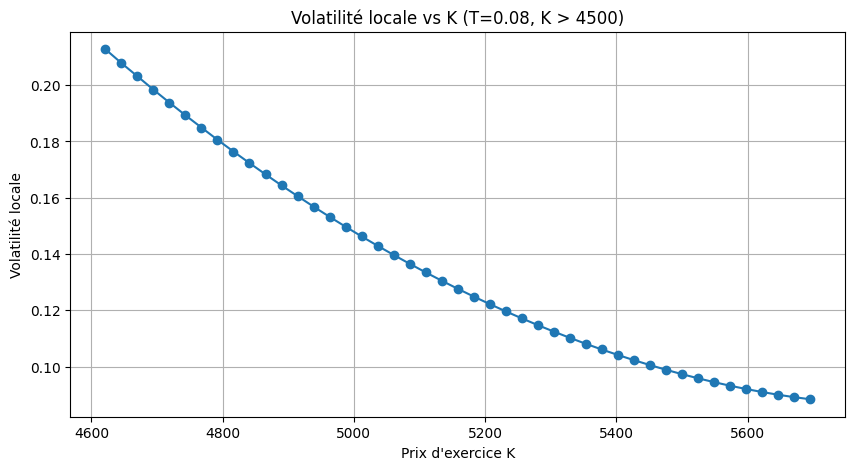

In [ ]:
T_target = 0.08
df_K = df[(df['T'] == T_target) & (df['K'] > 4600)]

plt.figure(figsize=(10, 5))
plt.plot(df_K['K'], df_K['local_vol'], marker='o')
plt.title(f"Volatilité locale vs K (T={T_target}, K > 4500)")
plt.xlabel("Prix d'exercice K")
plt.ylabel("Volatilité locale")
plt.grid(True)
plt.show()

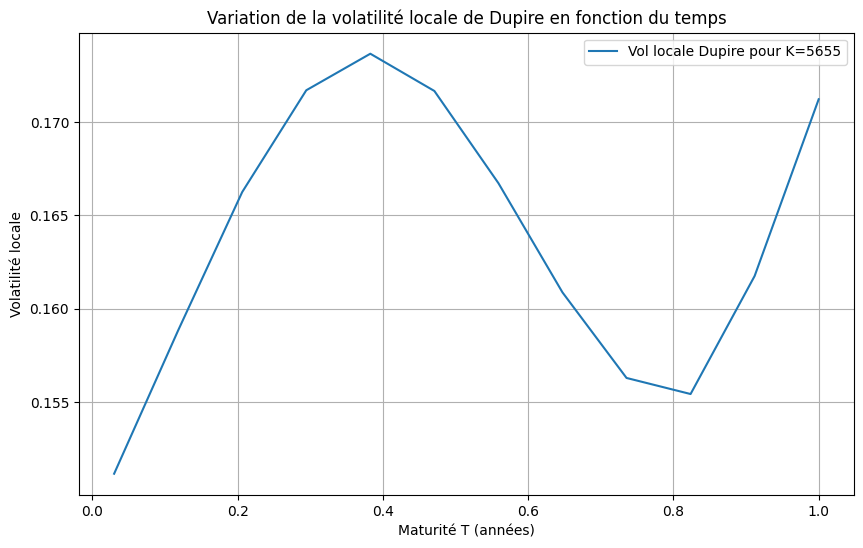

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
spot = 5655
K_calc = 5655
r = 0.01921
q = 0.02

# Grille de maturités
T_values = np.linspace(0.03, 1.0, 12)
local_vols = []

# Boucle sur les maturités
for T in T_values:
    try:
        vol = calculate_dupire_local_vol(T=T, K=K_calc, spot=spot, r=r, q=q)
        local_vols.append(vol)
    except Exception as e:
        local_vols.append(np.nan)  # En cas d'erreur, on insère NaN

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(T_values, local_vols, label=f"Vol locale Dupire pour K={K_calc}")
plt.xlabel("Maturité T (années)")
plt.ylabel("Volatilité locale")
plt.title("Variation de la volatilité locale de Dupire en fonction du temps")
plt.grid(True)
plt.legend()
plt.show()

[T=0.08, K=4524.0] ⚠️ Variance locale négative ou nulle : -4.537840731854573e-07
[T=0.08, K=6786.0] ⚠️ Variance locale négative ou nulle : -1.3593530651253482e-07


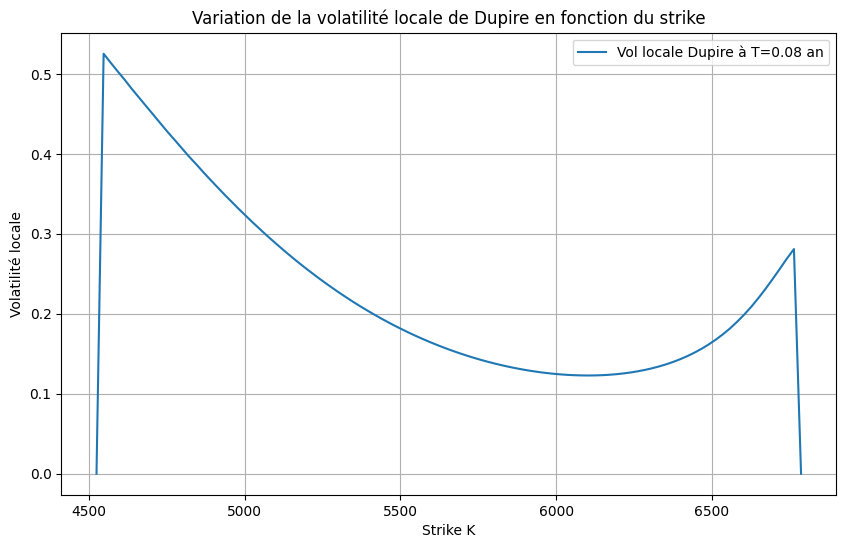

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
spot = 5655
T_fixed = 0.08  # Maturité fixe (en années)
r = 0.04
q = 0.02

# Grille de strikes autour du spot
K_values = np.linspace(0.8 * spot, 1.2 * spot, 100)
local_vols = []

# Boucle sur les strikes
for K in K_values:
    try:
        vol = calculate_dupire_local_vol(T=T_fixed, K=K, spot=spot, r=r, q=q)
        local_vols.append(vol)
    except Exception as e:
        local_vols.append(np.nan)  # En cas d'erreur, on insère NaN

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(K_values, local_vols, label=f"Vol locale Dupire à T={T_fixed:.2f} an")
plt.xlabel("Strike K")
plt.ylabel("Volatilité locale")
plt.title("Variation de la volatilité locale de Dupire en fonction du strike")
plt.grid(True)
plt.legend()
plt.show()

# Scénario 2 - Simulation Dupire daily


1. Configuration : taux & surface de vol.implicite

'Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50' (%):
          80%   90%   95%  100%  105%  110%  120%
0.00 an  88.9  59.0  36.8  17.0  23.5  37.1  53.3
0.08 an  36.2  24.0  18.7  14.4  12.1  13.2  20.4
0.25 an  27.8  21.0  18.1  15.6  13.9  13.1  13.8
0.50 an  24.9  20.0  17.7  15.9  14.6  13.8  13.2
1.00 an  22.9  19.5  18.0  16.7  16.1  15.7  14.9


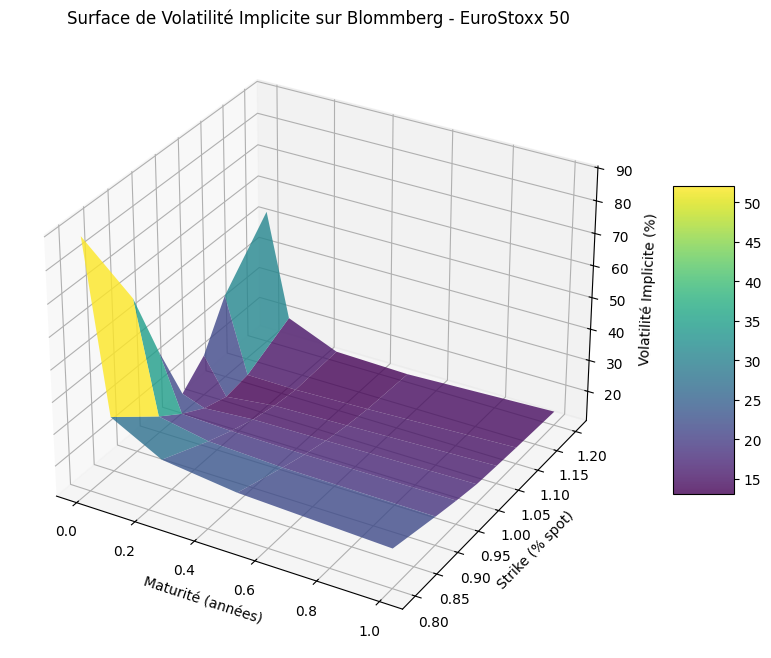

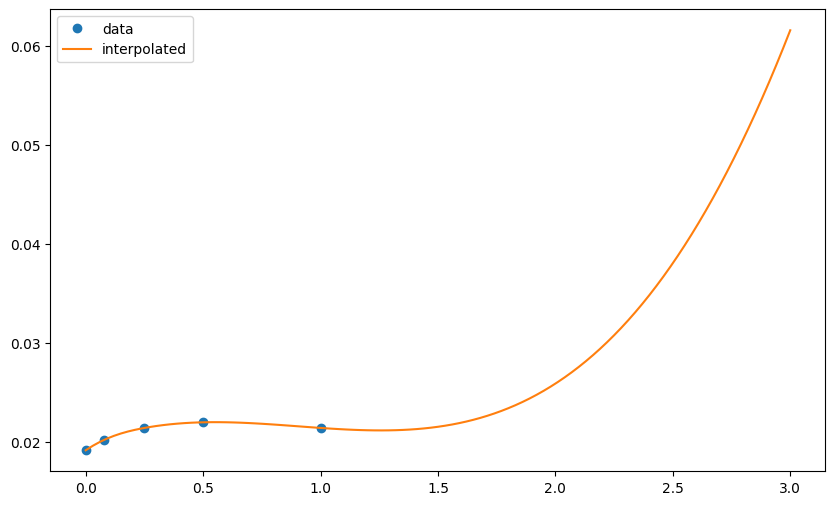

In [3]:
from scipy import interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# ************ 1. collecte des données   ***************************
T = np.array ( [0.003, 0.08, 0.25, 0.5, 1.0 ] )  # Maturité en année
K = np.array (( 0.8,   0.9,  0.95, 1.0, 1.05, 1.1, 1.2 ) )     # spot price

# from mpl_toolkits.mplot3d import Axes3D

spot_price = 5655     # Prix spot fictif de l'EuroStoxx 50

# Grille de maturités (en années)
maturities = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ])
#maturities = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ] )

# Grille de strikes (en % du spot)
strike_ratios = np.array([0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.2])
strikes = strike_ratios * spot_price

# Surface de volatilité implicite fictive (en %) # Dimensions: 5 maturités × 7 strikes
iv_matrix = np.array([
    # 80%    90%    95%    100%    105%    110%    120%  (strike ratios)
    [88.94, 59.04, 36.85,  16.97,  23.49,  37.12,  53.28],  # 1 day (0.003 an)   07/11/2027
    [36.19, 24.03, 18.72,  14.41,  12.07,  13.24,  20.37],  # 1 mois (0.08 an) 5/12/2025
    [27.79, 21.00, 18.06,  15.58,  13.92,  13.08,  13.76],  # 3 mois (0.25 an) 20/02/2026
    [24.91, 19.95, 17.74,  15.91,  14.60,  13.79,  13.15],  # 6 mois (0.5 an)  15/05/2026
    [22.91, 19.52, 17.98,  16.68,  16.13,  15.66,  14.89],  # 1 an (1.0 an)    20/11/2026

])

# Création d'un DataFrame pour une meilleure visualisation
iv_df = pd.DataFrame(
    iv_matrix,
    index=[f'{m:.2f} an' for m in maturities],
    columns=[f'{ratio:.0%}' for ratio in strike_ratios]
)

print("'Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50' (%):")
print(iv_df.round(1))
# IV_surface = interpolate.rectBivaruateSoline(T,K,IV,kx=3,ky=3,s=0.1)
# IV_surface = iv_df
# print(IV_surface.round(1))

# Création de la grille
T_mesh, K_mesh = np.meshgrid(maturities, strike_ratios)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface 3D
surf = ax.plot_surface(T_mesh, K_mesh, iv_matrix.T, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)

ax.set_xlabel('Maturité (années)')
ax.set_ylabel('Strike (% spot)')
ax.set_zlabel('Volatilité Implicite (%)')
ax.set_title('Surface de Volatilité Implicite sur Blommberg - EuroStoxx 50')

plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

from scipy import interpolate

# Taux sans risque r(T):
rates_dates = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ])

rates_values = np.array([0.01921, 0.02023, 0.02142, 0.02199, 0.02142])  # taux
rate_curve = interpolate.interp1d(rates_dates, rates_values,kind='cubic', fill_value='extrapolate')
r = rate_curve(T)

# Taux de dividende q(T):
# Méthode 1: Dividendes implicites depuis les forwards
# Méthode 2: Dividendes explicites actualisés q = 0.02

dividend_dates = np.array([0.003, 0.08, 0.25, 0.5, 1.0 ])

dividend_values = np.array([0.02, 0.02, 0.02, 0.02, 0.02])  # taux
dividend_curve = interpolate.interp1d(rates_dates, rates_values, kind='cubic', fill_value='extrapolate')

q = dividend_curve(T)

# plot zc curve interpolated
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
maturities = np.linspace(0, 3, num=101, endpoint=True)
plt.plot(rates_dates, rates_values, 'o', maturities, rate_curve(maturities))
plt.legend(['data', 'interpolated'], loc='best')
plt.show()

2. Interpolation de la surface de volatilité implicite Bloomberg SXE5

In [8]:
# *******************************************************
T_array = T
K_array = strikes
IV_array = iv_matrix / 100  # Conversion en decimal (0.225 au lieu de 22.5%)

# Création de la surface d'interpolation
iv_surface = interpolate.RectBivariateSpline(
    T_array, K_array, IV_array,
    kx=3, ky=3, s=0.1  # s = paramètre de lissage
)

# Exemple d'évaluation en un point
T_test = 0.08  # 9 mois
K_test = 5655  # strike

iv_interpolated = iv_surface(T_test, K_test)[0][0]
print(f"Vol implicite interpolée pour T={T_test} an, K={K_test}: {iv_interpolated:.1%}")
# Output: Vol implicite interpolée pour T=0.75 an, K=4000: 19.5% ```

# Vérification de la Surface

def check_surface_quality(iv_surface, T_array, K_array):
    """Vérifie que la surface interpolée est raisonnable"""

    # Test de monotonie
    print("Vérification de la surface...")

    # Test sur des points intermédiaires
    test_points = [
        (0.08, 4480), (0.15, 4480),(0.25, 4480), (0.4, 4480),(0.5, 4480), (0.75, 4480), (1.0, 4480),
        (0.08, 6720), (0.15, 3500), (0.4, 3700), (0.75, 3900), (1.5, 4100)
    ]

    for T, K in test_points:
        iv = iv_surface(T, K)[0][0]
        print(f"T={T:.2f}, K={K}: vol = {iv:.1%}")

    return True

# check_surface_quality(iv_surface, T_array, K_array)
check_surface_quality(iv_surface, T, K)

Vol implicite interpolée pour T=0.08 an, K=5655: 18.9%
Vérification de la surface...
T=0.08, K=4480: vol = 50.4%
T=0.15, K=4480: vol = 31.6%
T=0.25, K=4480: vol = 18.7%
T=0.40, K=4480: vol = 19.5%
T=0.50, K=4480: vol = 27.7%
T=0.75, K=4480: vol = 48.1%
T=1.00, K=4480: vol = 22.7%
T=0.08, K=6720: vol = 26.9%
T=0.15, K=3500: vol = 31.6%
T=0.40, K=3700: vol = 19.5%
T=0.75, K=3900: vol = 48.1%
T=1.50, K=4100: vol = 22.7%


True

 2. Fonction " Calcul Dupire local vol"

In [6]:

def calculate_dupire_local_vol(T, K, spot, r, q):
    # 1. Volatilité implicite et ses dérivées
    iv = iv_surface(T, K)[0][0]
    if iv == 0:
        print(f"[T={T}, K={K}] ⚠️ Volatilité implicite nulle")

    # Dérivée par rapport au temps
    dT = 0.001
    iv_T_plus = iv_surface(T + dT, K)[0][0]
    dIV_dT = (iv_T_plus - iv) / dT

    # Dérivée première par rapport à K
    dK = 0.01 * spot
    iv_K_plus = iv_surface(T, K + dK)[0][0]
    iv_K_minus = iv_surface(T, K - dK)[0][0]
    dIV_dK = (iv_K_plus - iv_K_minus) / (2 * dK)

    # Dérivée seconde par rapport à K
    d2IV_dK2 = (iv_K_plus - 2 * iv + iv_K_minus) / (dK ** 2)

    # 2. Calcul de d+
    try:
        d_plus = (np.log(spot / K) + (r - q + 0.5 * iv ** 2) * T) / (iv * np.sqrt(T))
    except ZeroDivisionError:
        print(f"[T={T}, K={K}] ⚠️ Division par zéro dans d_plus")
        return 0

    # 3. Application formule Dupire
    numerator = 2 * dIV_dT + iv / T + 2 * K * (r - q) * dIV_dK
    denominator_term1 = d2IV_dK2
    print(f"[T={T}, K={K}]")
    print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
    denominator_term2 = -d_plus * np.sqrt(T) * (dIV_dK) ** 2
    denominator_term3 = (1 / iv) * (1 / (K * np.sqrt(T)) + d_plus * dIV_dK) ** 2

    denominator = K ** 2 * (denominator_term1 + denominator_term2 + denominator_term3)
#--------------------------------------------------------------------------------------------------------------------------------------
#    if denominator == 0:
#       print(f"[T={T}, K={K}] ⚠️ Dénominateur exactement nul dans la formule de Dupire")
#        return 0
#    elif denominator < 0:
#        print(f"[T={T}, K={K}] ⚠️ Dénominateur négatif dans la formule de Dupire : {denominator}")
#        return 0


#   if denominator == 0:
#        print(f"[T={T}, K={K}] ⚠️ Dénominateur exactement nul dans la formule de Dupire")
#        print(f"  ➤ Termes du dénominateur :")
#        print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
#        print(f"     - Term2 (-d⁺√T·(dIV/dK)²) = {denominator_term2}")
#        print(f"     - Term3 (1/IV · ...)     = {denominator_term3}")
#        return 0
#    elif denominator < 0:
#         print(f"[T={T}, K={K}] ⚠️ Dénominateur négatif dans la formule de Dupire : {denominator}")
#         print(f"  ➤ Termes du dénominateur :")
#         print(f"     - Term1 (d²IV/dK²)       = {denominator_term1}")
#         print(f"     - Term2 (-d⁺√T·(dIV/dK)²) = {denominator_term2}")
#         print(f"     - Term3 (1/IV · ...)     = {denominator_term3}")
#         return 0

# -------------------------------------------------------------------------------------------------------------------------------------------
    local_var = numerator / denominator
    if local_var <= 0:
        print(f"[T={T}, K={K}] ⚠️ Variance locale négative ou nulle : {local_var}")
        return 0

    return np.sqrt(local_var)
# -------------------------------------------------------------------------------------------------------------------------------------------

# !!!!!!!!!! Grille de calcul: !!!!!!!!!!!!!!!!!  version détecter vol locale = 0  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
T_grid = T #_array
K_grid = K #_array

local_vol_grid = np.zeros((len(T_grid), len(K_grid)))

for i, T_val in enumerate(T_grid):
    for j, K_val in enumerate(K_grid):
        r_val = rate_curve(T_val)
        q_val = dividend_curve(T_val)  # si disponible

        # calculate_dupire_local_vol( T_val, K_val, spot_price, r_val, q_val)

        vol = calculate_dupire_local_vol(T_val, K_val, spot_price, r_val, q_val)

        if vol == 0:
            print(f"⚠️ Alerte : Volatilité locale nulle détectée pour T={T_val}, K={K_val} — valeur ignorée.")
            continue  # saute cette itération

        local_vol_grid[i, j] = vol

print("\nGrille de volatilité locale :")
for i, T_val in enumerate(T_grid):
    for j, K_val in enumerate(K_grid):
        vol = local_vol_grid[i, j]
        print(f"Vol[T={T_val:.4f}, K={K_val:.2f}] = {vol:.6f}")

print(local_vol_grid)



NameError: name 'iv_surface' is not defined

In [ ]:
# Paramètres EuroStoxx 50
spot = 5655  # prix spot SX5E
T_calc = 0.08  # 1 an
K_calc = 5655  # strike

# Calcul pour un point
local_vol = calculate_dupire_local_vol(
    T=T_calc,
    K=K_calc,
    spot=spot,
    r=0.01921,      # taux 1 an
    q=0.02       # dividende
)

print(f"Volatilité locale pour T={T_calc}, K={K_calc}: {local_vol:.1%}")

[T=0.08, K=5655]
     - Term1 (d²IV/dK²)       = 1.1399625521209146e-07
Volatilité locale pour T=0.08, K=5655: 15.5%


[T=0.03, K=5655]
     - Term1 (d²IV/dK²)       = 1.6320603521034952e-07
[T=0.11818181818181818, K=5655]
     - Term1 (d²IV/dK²)       = 8.425331797696413e-08
[T=0.20636363636363636, K=5655]
     - Term1 (d²IV/dK²)       = 3.831379235109984e-08
[T=0.29454545454545455, K=5655]
     - Term1 (d²IV/dK²)       = 1.8731974563070568e-08
[T=0.3827272727272727, K=5655]
     - Term1 (d²IV/dK²)       = 1.8852380843563392e-08
[T=0.47090909090909094, K=5655]
     - Term1 (d²IV/dK²)       = 3.201952742294426e-08
[T=0.5590909090909091, K=5655]
     - Term1 (d²IV/dK²)       = 5.157793053176139e-08
[T=0.6472727272727273, K=5655]
     - Term1 (d²IV/dK²)       = 7.087210640049356e-08
[T=0.7354545454545455, K=5655]
     - Term1 (d²IV/dK²)       = 8.32465712596543e-08
[T=0.8236363636363636, K=5655]
     - Term1 (d²IV/dK²)       = 8.204584133977443e-08
[T=0.9118181818181819, K=5655]
     - Term1 (d²IV/dK²)       = 6.061443287128068e-08
[T=1.0, K=5655]
     - Term1 (d²IV/dK²)       = 1.2296862084712586e-08


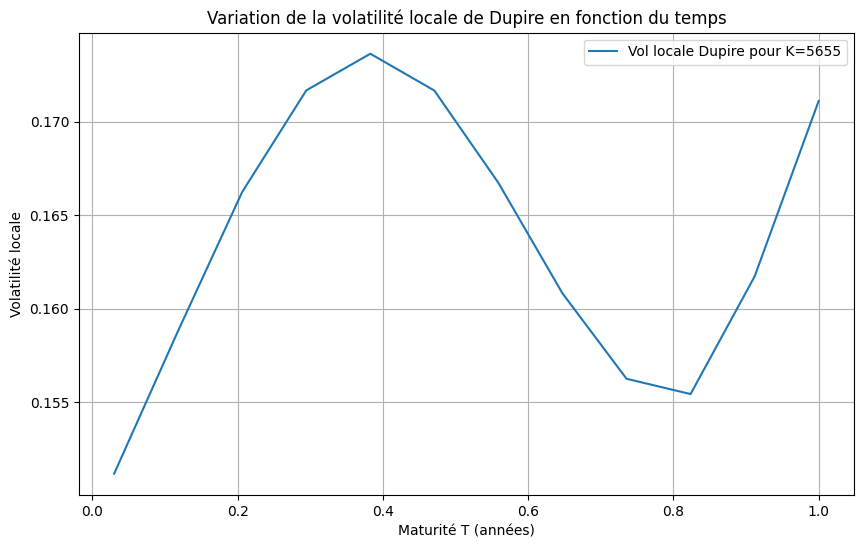

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
spot = 5655
K_calc = 5655
r = 0.01921
q = 0.02

# Grille de maturités
T_values = np.linspace(0.03, 1.0, 12)
local_vols = []

# Boucle sur les maturités
for T in T_values:
    try:
        vol = calculate_dupire_local_vol(T=T, K=K_calc, spot=spot, r=r, q=q)
        local_vols.append(vol)
    except Exception as e:
        local_vols.append(np.nan)  # En cas d'erreur, on insère NaN

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(T_values, local_vols, label=f"Vol locale Dupire pour K={K_calc}")
plt.xlabel("Maturité T (années)")
plt.ylabel("Volatilité locale")
plt.title("Variation de la volatilité locale de Dupire en fonction du temps")
plt.grid(True)
plt.legend()
plt.show()

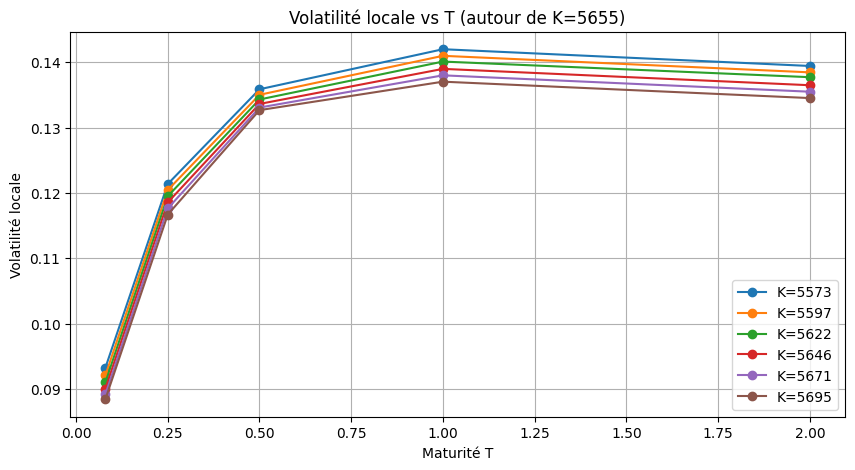

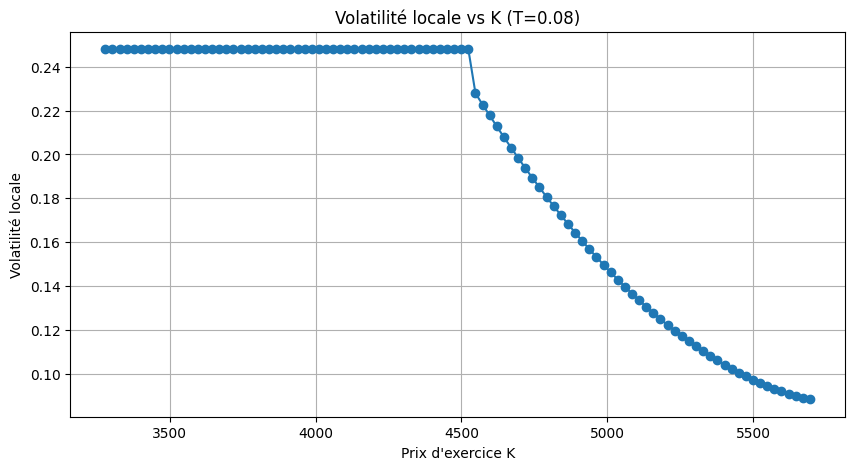

In [ ]:
# Plot 1 : Volatilité locale en fonction de T pour un K fixe - Low point pendant 5ans : 3279
K_target = 5655
df_T = df[np.abs(df['K'] - K_target) < pas]  # tolérance autour de K_target

plt.figure(figsize=(10, 5))
for k in sorted(df_T['K'].unique()):
    subset = df_T[df_T['K'] == k]
    plt.plot(subset['T'], subset['local_vol'], marker='o', label=f'K={k:.0f}')
plt.title(f"Volatilité locale vs T (autour de K={K_target})")
plt.xlabel("Maturité T")
plt.ylabel("Volatilité locale")
plt.legend()
plt.grid(True)
plt.show()

#___________________________________________________________________

# 📈 Plot 2 : Volatilité locale en fonction de K pour un T fixe monthly
T_target = 0.08
df_K = df[df['T'] == T_target]

plt.figure(figsize=(10, 5))
plt.plot(df_K['K'], df_K['local_vol'], marker='o')
plt.title(f"Volatilité locale vs K (T={T_target})")
plt.xlabel("Prix d'exercice K")
plt.ylabel("Volatilité locale")
plt.grid(True)
plt.show()

[T=0.08, K=4524.0]
     - Term1 (d²IV/dK²)       = -2.7472690643796837e-06
[T=0.08, K=4524.0] ⚠️ Dénominateur négatif dans la formule de Dupire : -33.93121796127514
  ➤ Termes du dénominateur :
     - Term1 (d²IV/dK²)       = -2.7472690643796837e-06
     - Term2 (-d⁺√T·(dIV/dK)²) = -4.6152986284619344e-09
     - Term3 (1/IV · ...)     = 1.0939999195489594e-06
[T=0.08, K=4546.848484848485]
     - Term1 (d²IV/dK²)       = -1.6264942186614512e-06
[T=0.08, K=4546.848484848485] ⚠️ Dénominateur négatif dans la formule de Dupire : -17.238566652653994
  ➤ Termes du dénominateur :
     - Term1 (d²IV/dK²)       = -1.6264942186614512e-06
     - Term2 (-d⁺√T·(dIV/dK)²) = -8.973287313721098e-09
     - Term3 (1/IV · ...)     = 8.016323772832115e-07
[T=0.08, K=4569.69696969697]
     - Term1 (d²IV/dK²)       = -5.080899614146547e-07
[T=0.08, K=4592.545454545455]
     - Term1 (d²IV/dK²)       = 2.325405328755172e-08
[T=0.08, K=4615.393939393939]
     - Term1 (d²IV/dK²)       = 2.5205498490186503e-08
[T

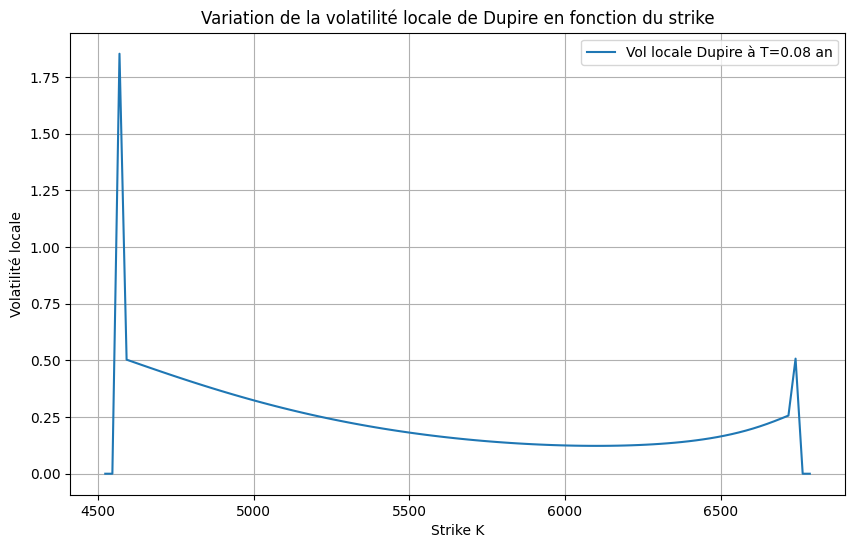

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
spot = 5655
T_fixed = 0.08  # Maturité fixe (en années)
r = 0.01921
q = 0.02

# Grille de strikes autour du spot
K_values = np.linspace(0.8 * spot, 1.2 * spot, 100)
local_vols = []

# Boucle sur les strikes
for K in K_values:
    try:
        vol = calculate_dupire_local_vol(T=T_fixed, K=K, spot=spot, r=r, q=q)
        local_vols.append(vol)
    except Exception as e:
        local_vols.append(np.nan)  # En cas d'erreur, on insère NaN

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(K_values, local_vols, label=f"Vol locale Dupire à T={T_fixed:.2f} an")
plt.xlabel("Strike K")
plt.ylabel("Volatilité locale")
plt.title("Variation de la volatilité locale de Dupire en fonction du strike")
plt.grid(True)
plt.legend()
plt.show()